In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline


In [15]:
data = pd.read_excel("support_files/OSEBX.xlsx")
data2 = pd.read_csv("support_files/OSEBX.OL (1).csv")

In [16]:
data.head()

,OSEBX,Last,High,Low,Official turnover (NOK)
0,2018-11-14,NaN,NaN,NaN,3.790000e+02
1,2018-11-13,875.43,887.95,875.17,5.126725e+09
2,2018-11-12,886.62,892.64,885.44,3.591581e+09
3,2018-11-09,886.44,892.58,884.16,4.405451e+09
4,2018-11-08,892.49,900.74,891.50,4.463838e+09


In [17]:
data.rename(columns={'OSEBX' : 'Date'}, inplace=True)

In [18]:
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4356 entries, 0 to 4355
Data columns (total 7 columns):
Date         4356 non-null object
Open         4275 non-null float64
High         4275 non-null float64
Low          4275 non-null float64
Close        4275 non-null float64
Adj Close    4275 non-null float64
Volume       4275 non-null float64
dtypes: float64(6), object(1)
memory usage: 238.3+ KB


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5743 entries, 0 to 5742
Data columns (total 5 columns):
Date                       5743 non-null datetime64[ns]
Last                       5742 non-null float64
High                       4390 non-null float64
Low                        4390 non-null float64
Official turnover (NOK)    5624 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 224.4 KB


In [21]:
data['Direction'] = data.Last.diff().shift()

In [22]:
data['Direction'] = data.Direction.apply(lambda x: 1 if x > 0 else 0)

In [25]:
data['Close'] = data.Last.shift()
data.drop('Last', axis=1, inplace=True)

In [29]:
data.set_value(1, 'Close', 876.30)
data.set_value(0, 'Close', 872.10);

C:\anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\anaconda\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


In [31]:
data = data[['Date', 'High', 'Low', 'Close', 'Official turnover (NOK)', 'Direction']].copy()

In [35]:
data.sort_values(by='Date', ascending=True);


In [37]:
data['MA10'] = data.Close.rolling(10).mean()
data['MA30'] = data.Close.rolling(30).mean()
data['MA120'] = data.Close.rolling(120).mean()


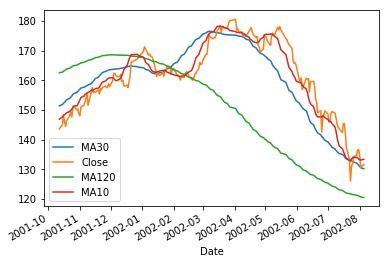

In [62]:
data.set_index('Date');

data.iloc[100:300].plot(x='Date', y=['MA30', 'Close', 'MA120', 'MA10'])


In [43]:
data.dropna(inplace=True)

In [137]:
def RSI (df, ):
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = pd.rolling_mean(dUp, n)
    RolDown = pd.rolling_mean(dDown, n).abs()

    RS = RolUp / RolDown

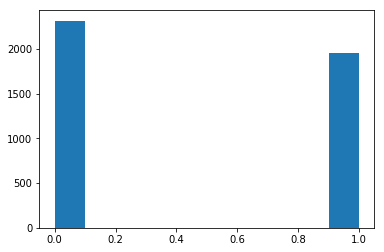

In [53]:
data.sort_values(by='Date', inplace=True)
plt.hist(data.Direction);
        

In [44]:
target = data.Direction


In [45]:
features = data.drop(["Direction", "Date"], axis=1)


In [46]:
norm = Normalizer()
features = norm.fit_transform(features)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30)

In [48]:
target.shape

(4271,)

In [49]:
clf = SVC(probability=True)

param_dist_svm = {
 'kernel': ['linear', 'rbf', 'poly'],
 'C' : [0.001,0.05,0.1]

 }

svmmodel = GridSearchCV(clf, param_grid=param_dist_svm )
svmmodel.fit(X_train, y_train);


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf', 'poly'], 'C': [0.001, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
y_pred = svmmodel.predict_proba(X_test)


In [51]:
def roc_scores (y_predict, y_test=y_test):
    
    # Compute for probabilities for positive outcome
    fpr, tpr, tresholds = roc_curve(y_test, y_predict[:,1])
    roc_auc = roc_auc_score(y_test, y_predict[:,1])

    return fpr, tpr, tresholds, roc_auc

def plot_roc(fpr, tpr, roc_auc, title="ROC"):
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right");

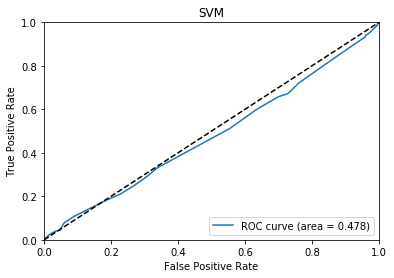

In [52]:
fpr, tpr, tresholds, roc_auc = roc_scores(y_pred)
plot_roc(fpr,tpr,roc_auc, 'SVM')

In [171]:
lr = LogisticRegression()

In [173]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [179]:
y_perd_lr = lr.predict_proba(X_test)

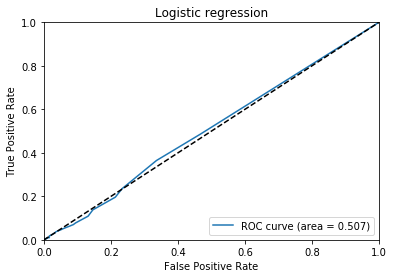

In [180]:
fpr, tpr, tresholds, roc_auc = roc_scores(y_perd_lr)
plot_roc(fpr,tpr,roc_auc, 'Logistic regression')

In [221]:
rf = RandomForestClassifier()

# specify parameters and distributions to sample from
param_dist1 = {"max_depth": [5,10,15,20],
              "n_estimators" : [100, 1000, 10000, 1000000000],
              "min_samples_split": [3,5,10,15,20],
              "bootstrap": [True, False],
              "min_samples_leaf" : [3,5,10,15,20]
                            }
n_iter_search = 20
randommodel = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=10, n_jobs=-1)
randommodel.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  2.0min remaining:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


In [222]:
rf_pred = randommodel.predict_proba(X_test)

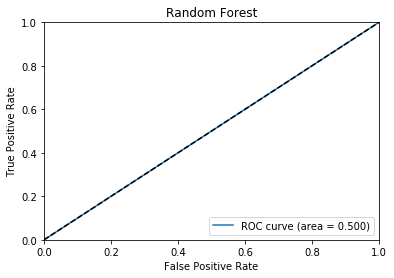

In [223]:
fpr, tpr, tresholds, roc_auc = roc_scores(rf_pred)
plot_roc(fpr,tpr,roc_auc, 'Random Forest')